In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def zero_pad(Y):
    mx, my = Y.shape
    padded_x = ((mx + 7) // 8) * 8
    padded_y = ((my + 7) // 8) * 8
    img = np.zeros((padded_x, padded_y), dtype=np.uint8)
    img[:mx, :my] = Y
    
    return img

def DCT(img):
    w, h = img.shape
    num_blocks = (w // 8) * (h // 8)
    dct_output = np.zeros((8, 8, num_blocks), dtype=float) 

    for ci, (i, j) in enumerate((x, y) for x in range(0, w, 8) for y in range(0, h, 8)):
        dct_output[:, :, ci] = cv2.dct(img[i:i+8, j:j+8].astype(np.float32))  # Ensure input is float for DCT

    return dct_output


def hist(DC, N=2000, show=False):
    hcount, bin_edges = np.histogram(DC, bins=N, density=True)
    if show:
        plt.figure(figsize=(10, 6))
        sns.histplot(x=bin_edges[:-1], weights=hcount, bins=N, kde=True, stat="density")
        plt.title("DC Coefficient Histogram")
        plt.xlabel("DC Coefficient Value")
        plt.ylabel("Density")
        plt.show()
    return hcount, bin_edges

def FFT(hcount):
  hcount -= np.mean(hcount)
  x = np.fft.fft(hcount.astype(float))
  x = abs(np.fft.fftshift(x))
#   x = savgol_filter(x, 11, 2)
  return x

def quality(x, N=2000):
    ref = x[N // 2 - 1]
    candidate_indices = np.where((x - ref) > -12)[0]

    local_maxs = [
        i for i in candidate_indices
        if 3 <= i < x.shape[0] - 3  
        and x[i] > x[i - 1] and x[i] > x[i + 1]
        and x[i] > x[i - 3] + 1 and x[i] > x[i + 3] + 1
    ]

    if len(local_maxs) <= 1:
        Q = 100
    else:
        distances = np.diff(local_maxs)
        average_distance = np.mean(distances)


        max_distance = 40   
        min_distance = 5   

        Q = 100 - (average_distance - min_distance) / (max_distance - min_distance) * 90
        Q = max(0, min(100, Q))  

    print("Average Distance:", average_distance if len(local_maxs) > 1 else "N/A")
    return round(Q), local_maxs

Average Distance: N/A
Quality of the image: 100


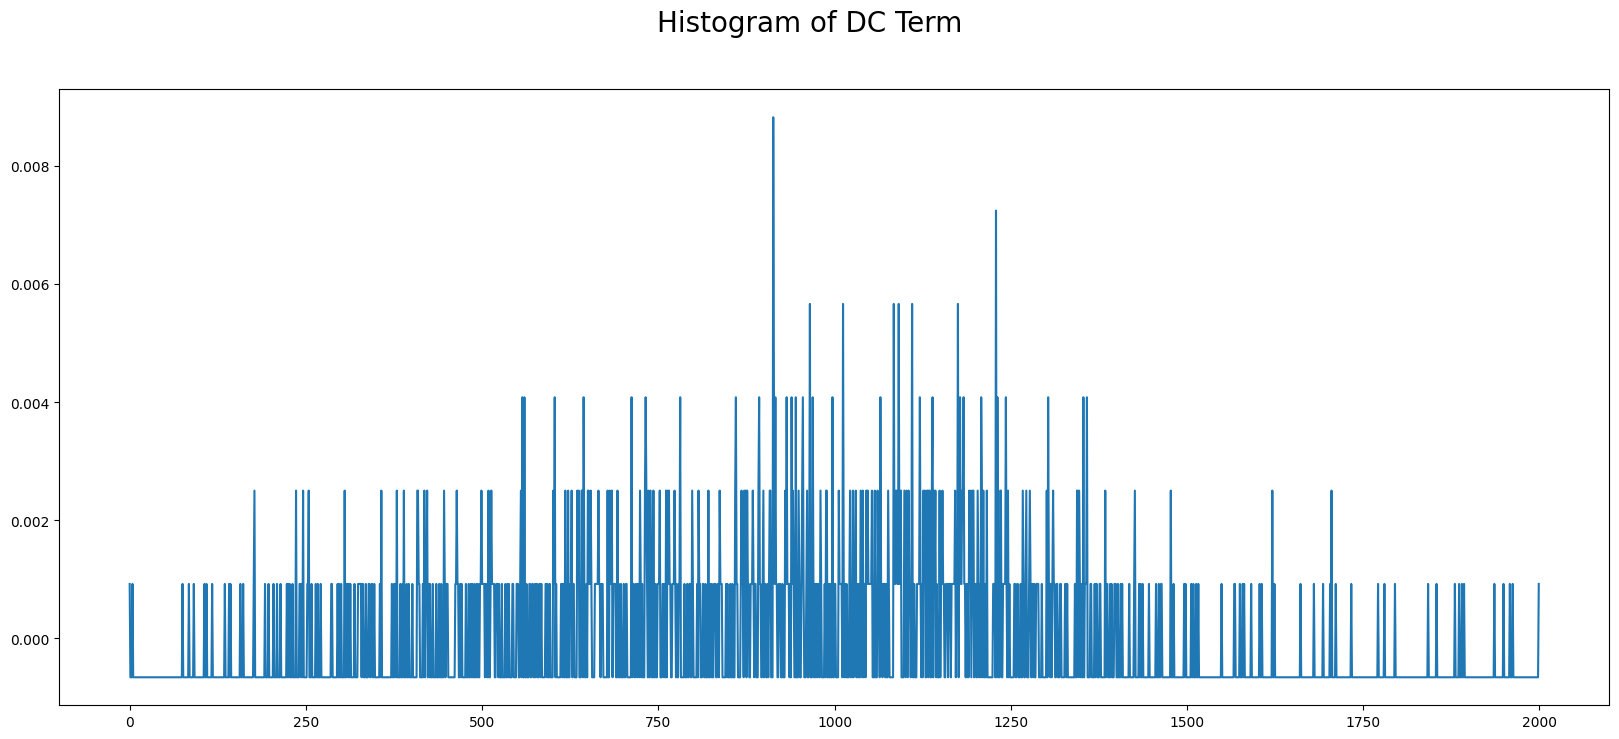

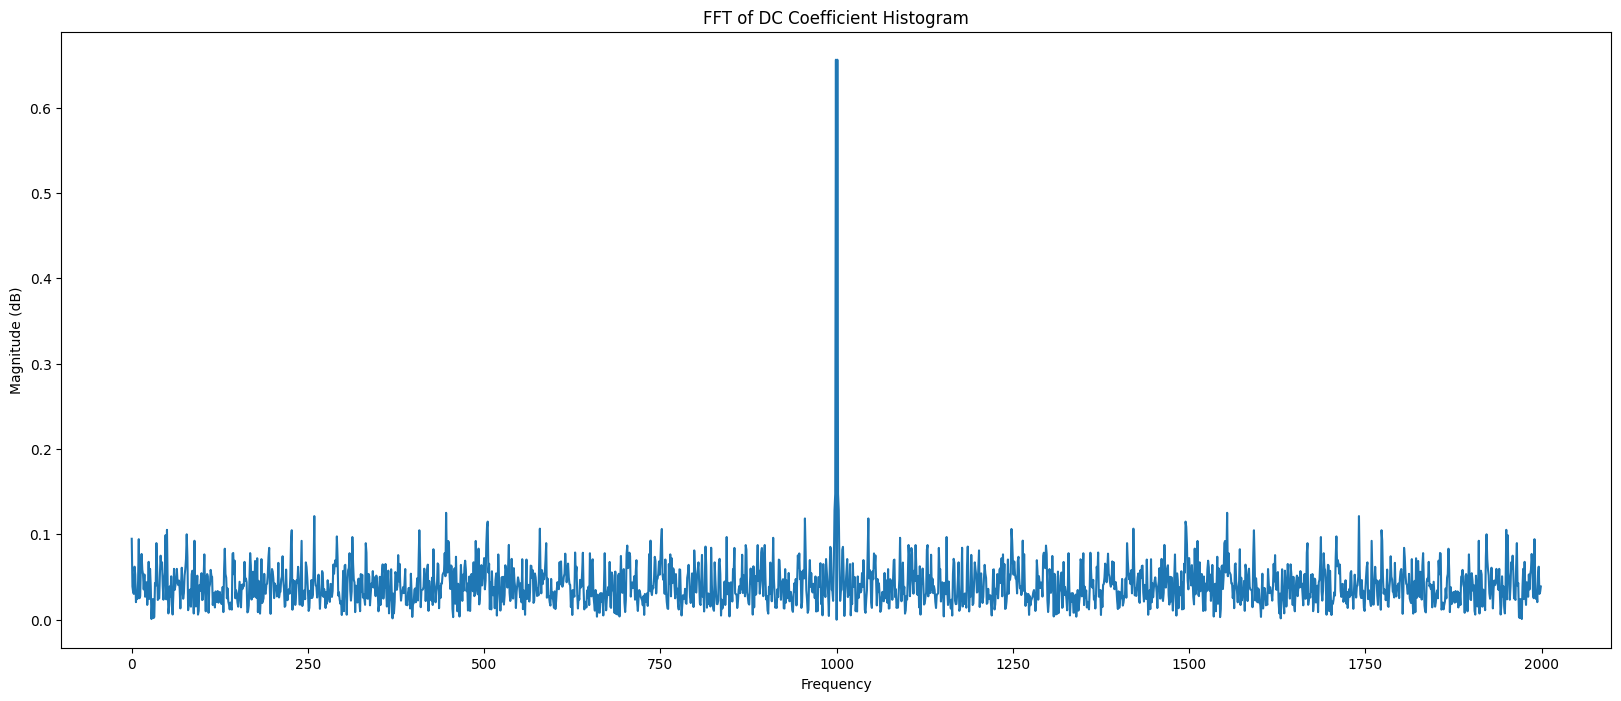

In [10]:
img = Image.open("0010x8.png")

img = img.convert('YCbCr')
img = zero_pad(np.array(img)[:,:,0])
img = img.astype(np.float64)
dct = DCT(img)[0,0,:]
hcount, bin_edges = hist(dct)
fft = FFT(hcount)
image_quality, max_list = quality(fft)
print(f"Quality of the image: {image_quality}")
fig = plt.figure(figsize=(20,8))
plt.plot(hcount)
fig.suptitle("Histogram of DC Term",fontsize=20)
plt.figure(figsize=(20, 8))
plt.plot(fft)
plt.title("FFT of DC Coefficient Histogram")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.show()